In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report
import numpy as np

# ✅ 초기 설정: 기존 모델 파일 삭제 및 디바이스 설정
# for file in ["photo_pretrained_dino.pth", "best_photo_model.pth", "best_drawing_model.pth"]:
    # if os.path.exists(file):
        # os.remove(file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📌 디바이스: {device}")

📌 디바이스: cuda


In [2]:
# ✅ 하이퍼파라미터
BATCH_SIZE = 16
LR_PHOTO = 1e-4
LR_DRAWING = 1e-5
EPOCHS_PHOTO = 15
EPOCHS_DRAWING = 30

In [3]:
# ✅ CBAM 모듈 정의
# CNN의 feature map에 대해 채널과 공간 단위로 중요한 정보를 강조하는 attention 기법
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()
    # 평균 pooling과 최대 pooling 결과를 MLP에 통과시킨 뒤 두 결과를 더해 sigmoid 적용. 이 결과를 attention mask로 사용
    # 각 채널에 대한 중요도를 0~1로 표현한 tensor
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    # sigmoid로 [0,1] 사이 값으로 정규화된 공간 attention map 생성
    # 어느 위치가 중요한지 표현된 2D mask
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

# channelAttention으로 채널을 강조한 뒤, spatialAttention으로 위치를 강조
# 두 단계 모두 입력 feature map과 element-wise 곱을 수행
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

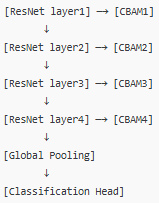

In [4]:
# ✅ ResNet50 + CBAM 정의
# 4개의 ResNet block 모두에 CBAM을 삽입해 분류 head를 개선
class ResNet50_CBAM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # weights 파라미터 사용 (pretrained는 deprecated)
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # CBAM을 여러 층에 추가
        # ResNet50은 각 블록의 출력 채널 수가 아래와 같기 때문에 해당 in_channels로 CBAM 생성
        # 각 block의 출력에 attention을 적용해 중요 채널 및 위치 강조
        self.cbam1 = CBAM(in_channels=256)   # layer1 output
        self.cbam2 = CBAM(in_channels=512)   # layer2 output
        self.cbam3 = CBAM(in_channels=1024)  # layer3 output
        self.cbam4 = CBAM(in_channels=2048)  # layer4 output

        # 기존 FC layer 제거(커스텀 classification을 활용할 예정)
        self.backbone.fc = nn.Identity()

        # classification head
        self.head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # 초기 layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        # ResNet blocks with CBAM
        x = self.backbone.layer1(x)
        x = self.cbam1(x)

        x = self.backbone.layer2(x)
        x = self.cbam2(x)

        x = self.backbone.layer3(x)
        x = self.cbam3(x)

        x = self.backbone.layer4(x)
        x = self.cbam4(x)

        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        return self.head(x)

In [5]:
# ✅ 데이터 전처리 정의
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
photo_dataset_train = datasets.ImageFolder('datasets/dataset2yolo/photo/train', transform=transform_train)
photo_dataset_val   = datasets.ImageFolder('datasets/dataset2yolo/photo/val', transform=transform_val)

drawing_dataset_train = datasets.ImageFolder('datasets/dataset2yolo/drawing/train', transform=transform_train)
drawing_dataset_val   = datasets.ImageFolder('datasets/dataset2yolo/drawing/val', transform=transform_val)

class_names = photo_dataset_train.classes
num_classes = len(class_names)
print(f"📊 감정 클래스 ({num_classes}개): {class_names}")

📊 감정 클래스 (4개): ['angry', 'fear', 'happy', 'sad']


In [8]:
# DataLoader 생성 (num_workers 조정)
num_workers = min(4, os.cpu_count() or 1)  # CPU 코어 수에 맞게 조정

photo_train_loader = DataLoader(photo_dataset_train, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False)
photo_val_loader = DataLoader(photo_dataset_val, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False)
drawing_train_loader = DataLoader(drawing_dataset_train, batch_size=BATCH_SIZE, shuffle=True,
                                 num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False)
drawing_val_loader = DataLoader(drawing_dataset_val, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False)

print(f"📊 데이터셋 크기:")
print(f"사진 - 학습: {len(photo_dataset_train)}, 검증: {len(photo_dataset_val)}")
print(f"그림 - 학습: {len(drawing_dataset_train)}, 검증: {len(drawing_dataset_val)}")

📊 데이터셋 크기:
사진 - 학습: 5756, 검증: 1440
그림 - 학습: 1539, 검증: 472


In [9]:
# ✅ 학습 및 검증 함수 정의
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total

    return val_loss, val_acc, all_preds, all_targets

# ✅ 모델 초기화
model = ResNet50_CBAM(num_classes=num_classes).to(device)
print(f"📌 모델이 {device}에 로드되었습니다.")
print(f"📌 총 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print(f"📌 학습 가능한 파라미터 수: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

📌 모델이 cuda에 로드되었습니다.
📌 총 파라미터 수: 25,387,724
📌 학습 가능한 파라미터 수: 25,387,724


In [12]:
import torch.optim as optim
# ========================================
# ✅ 1단계: 사진 데이터로 Pretraining
# ========================================
print("\n📸 [1단계] 사진 데이터로 Pretraining 시작")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = photo_train_loader
val_loader = photo_val_loader
class_names = photo_dataset_train.classes

EPOCHS_PRETRAIN = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(EPOCHS_PRETRAIN):
    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS_PRETRAIN}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_targets = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"✅ [Train] Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"🎯 [Val]   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")




📸 [1단계] 사진 데이터로 Pretraining 시작

🔁 Epoch 1/10


Batch 0/360, Loss: 1.1900
Batch 10/360, Loss: 0.8686
Batch 20/360, Loss: 1.1465
Batch 30/360, Loss: 1.0513
Batch 40/360, Loss: 0.8737
Batch 50/360, Loss: 0.9113
Batch 60/360, Loss: 1.2079
Batch 70/360, Loss: 0.8352
Batch 80/360, Loss: 0.8880
Batch 90/360, Loss: 1.1265
Batch 100/360, Loss: 0.6032
Batch 110/360, Loss: 0.8664
Batch 120/360, Loss: 0.6939
Batch 130/360, Loss: 0.6617
Batch 140/360, Loss: 1.1483
Batch 150/360, Loss: 0.6316
Batch 160/360, Loss: 0.7781
Batch 170/360, Loss: 0.8857
Batch 180/360, Loss: 0.4334
Batch 190/360, Loss: 0.7495
Batch 200/360, Loss: 1.1071
Batch 210/360, Loss: 0.7944
Batch 220/360, Loss: 0.8473
Batch 230/360, Loss: 0.7920
Batch 240/360, Loss: 0.8140
Batch 250/360, Loss: 0.6153
Batch 260/360, Loss: 0.7082
Batch 270/360, Loss: 0.6944
Batch 280/360, Loss: 1.1197
Batch 290/360, Loss: 0.9973
Batch 300/360, Loss: 0.6996
Batch 310/360, Loss: 0.7607
Batch 320/360, Loss: 0.6780
Batch 330/360, Loss: 0.6776
Batch 340/360, Loss: 0.7648
Batch 350/360, Loss: 1.0489
✅ [

In [13]:
# ========================================
# ✅ 2단계: 그림 데이터로 Fine-tuning
# ========================================
print("\n🖼️ [2단계] 그림 데이터로 Fine-tuning 시작")

# (선택) 특정 레이어 Freeze
for name, param in model.named_parameters():
    if 'fc' not in name:  # 분류 헤드 제외하고 Freeze
        param.requires_grad = False

# (필수) 옵티마이저 다시 정의 (freeze 반영)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# 그림 데이터 DataLoader 적용
train_loader = drawing_train_loader
val_loader = drawing_val_loader
class_names = drawing_dataset_train.classes

EPOCHS_FINETUNE = 10
ft_train_losses, ft_train_accuracies = [], []
ft_val_losses, ft_val_accuracies = [], []

best_acc = 0.0
patience = 3
wait = 0

for epoch in range(EPOCHS_FINETUNE):
    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS_FINETUNE}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_targets = validate(model, val_loader, criterion, device)

    ft_train_losses.append(train_loss)
    ft_train_accuracies.append(train_acc)
    ft_val_losses.append(val_loss)
    ft_val_accuracies.append(val_acc)

    print(f"✅ [FT-Train] Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"🎯 [FT-Val]   Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        wait = 0
        torch.save(model.state_dict(), "/workspace/models/best_CNNattention_drawing_model.pth")
        print(f"💾 Best model saved! (val_acc = {val_acc:.2f}%)")
    else:
        wait += 1
        print(f"⏳ No improvement. Patience: {wait}/{patience}")
        if wait >= patience:
            print("🛑 Early stopping triggered.")
            break



🖼️ [2단계] 그림 데이터로 Fine-tuning 시작

🔁 Epoch 1/10


Batch 0/97, Loss: 2.8488
Batch 10/97, Loss: 2.7068
Batch 20/97, Loss: 3.2304
Batch 30/97, Loss: 1.1919
Batch 40/97, Loss: 3.0619
Batch 50/97, Loss: 2.6732
Batch 60/97, Loss: 4.1255
Batch 70/97, Loss: 2.8306
Batch 80/97, Loss: 2.0819
Batch 90/97, Loss: 3.1861
✅ [FT-Train] Loss: 2.9074 | Accuracy: 30.60%
🎯 [FT-Val]   Loss: 3.1832 | Accuracy: 25.00%
💾 Best model saved! (val_acc = 25.00%)

🔁 Epoch 2/10
Batch 0/97, Loss: 2.7312
Batch 10/97, Loss: 2.6045
Batch 20/97, Loss: 3.4177
Batch 30/97, Loss: 3.0810
Batch 40/97, Loss: 2.9214
Batch 50/97, Loss: 2.4789
Batch 60/97, Loss: 3.3856
Batch 70/97, Loss: 3.6771
Batch 80/97, Loss: 3.8162
Batch 90/97, Loss: 3.2634
✅ [FT-Train] Loss: 2.8872 | Accuracy: 30.21%
🎯 [FT-Val]   Loss: 3.1950 | Accuracy: 23.52%
⏳ No improvement. Patience: 1/3

🔁 Epoch 3/10
Batch 0/97, Loss: 3.5186
Batch 10/97, Loss: 2.3872
Batch 20/97, Loss: 4.2308
Batch 30/97, Loss: 3.2246
Batch 40/97, Loss: 2.1315
Batch 50/97, Loss: 3.9645
Batch 60/97, Loss: 2.6712
Batch 70/97, Loss: 3.3

In [14]:
from sklearn.metrics import classification_report, accuracy_score

# 따로 실행하고 싶을 때 사용. tuning 이후 바로 실행 시 아래 코드 그대로 사용.
# model.load_state_dict(torch.load("/workspace/models/best_CNNattention_drawing_model.pth"))
# model.eval()
# val_loss, val_acc, val_preds, val_targets = validate(model, val_loader, criterion, device)

print("\n📋 Classification Report (Per Class):")
report = classification_report(
    val_targets,
    val_preds,
    target_names=class_names,
    digits=4
)
print(report)

accuracy = accuracy_score(val_targets, val_preds)
print(f"\n✅ Overall Accuracy: {accuracy * 100:.2f}%")


📋 Classification Report (Per Class):
              precision    recall  f1-score   support

       angry     0.2566    0.3900    0.3095       100
        fear     0.1624    0.2043    0.1810        93
       happy     0.4767    0.2253    0.3060       182
         sad     0.2906    0.3505    0.3178        97

    accuracy                         0.2818       472
   macro avg     0.2966    0.2925    0.2786       472
weighted avg     0.3299    0.2818    0.2845       472


✅ Overall Accuracy: 28.18%
